# Assignment Instructions
## Completing the Assignment  
1. Fill in your STUDENTID (abc123) in the code block below.
2. Fill in any place that says `#YOUR CODE HERE` with python code that implements the indicated function.
3. When filling in `#YOUR CODE HERE` sections, remove or comment out the line  `raise NotImplementedError()`, or else you will lose all credit for that function.
4. Fill in any place that says `YOUR ANSWER HERE` with appropriate markdown text. This usually indicates a manually graded cell.

## Assignment Submission Checklist  
Before you submit this assignment for grading, you must do the following or you risk losing points. 
1. **Remove Extraneous prints** Long prints _might_ confuse the grader. If they do, you lose points.
2. **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
3. **Run all cells** (in the menubar, select Cell$\rightarrow$Run All).  
  - If any cell that contains code throws an exception or does not compile, fix it and restart this checklist 
  - If a grading cell throws an exception, you will not recieve any credit for that cell
4. **Save the notebook** This ensures that any graphs or plots are in the submission   
  - Do NOT rename your notebook. It must have the same name that was downloaded, or the grading will fail.  
5. **Zip up the assignment notebook(s) and any files required to run the notebook**
  - You must put your files into a `.zip` file with the same name that was used to download the assignment. For example `ASnn.zip` or `PRnn.zip` where nn is a two digit, zero padded number.
  - All files must be in the root of the zip file, NOT in a subdirectory

By submitting this notebook for grading, you affirm that all work was produced by the author identified below, and that references are included for all use of public source material (to include code, data, diagrams, pictures, and verbatim text).

In [1]:
STUDENTID = "tfs436"

---

# AS08 - Modeling Text Data
**Version:**  1.4

**Total Points:** 5

## Objective
The objective of this assignment is to predict whether an Amazon Fine Food review is negative, neutral, or positive. The general organization and presentation of this notebook is a reasonable model for how to present your projects.

## Data Source
For this assignment we will be using the **Amazon Fine Food Reviews** dataset available on [Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews). The data along with the referenced paper have been downloaded to the Datasets directory.

| Feature Name | Feature Description |
| :---- | :---- |
| Id |            Row Id |
| ProductId |     Unique identifier for the product |
| UserId    |     Unqiue identifier for the user |
| ProfileName |   Profile name of the user |
| HelpfulnessNumerator |   Number of users who found the review helpful  |
| HelpfulnessDenominator | Number of users who indicated whether they found the review helpful or not |
| Score    |      Rating between 1 and 5 |
| Time     |      Timestamp for the review |
| Summary  |      Brief summary of the review |
| Text     |      Text of the review |



## Instructions

Be sure to read the instructions and guidelines provided for each portion of this assignment.  The number of points earned is in parenthesis next to the description in the table of contents below.

[Setup](#Setup)  

**Reading, cleaning, and exploring the data**  
[Exercise 1 - Remove duplicate entries](#Exercise-1---Remove-duplicate-entries)  (0.2)  
[Exercise 2 - Check the class balance](#Exercise-2---Check-the-class-balance)  (0.2)  
[Exercise 3 - Remove html](#Exercise-3---Remove-html) (0.2)  
[Exercise 4 - Expand common contractions](#Exercise-4---Expand-common-contractions) (0.2)  
[Exercise 5 - Separate words that are joined by slashes or hyphens](#Exercise-5---Separate-words-that-are-joined-by-slashes-or-hyphens) (0.4)  
[Exercise 6 - Final cleaning](#Exercise-6---Final-cleaning) (0.5)  

**Prepare data for vectorizing**  
[Exercise 7 - See how much lemmatization costs](#Exercise-7---See-how-much-lemmatization-costs) (1.0)  

**Vectorizing and Modeling**  
[Exercise 8 - Create stopword list](#Exercise-8---Create-stopword-list) (0.3)   
[Exercise 9 - CountVectorize](#Exercise-9---CountVectorize) (0.4)  
[Exercise 10 - Naive Bays Model](#Exercise-10---Naive-Bays-Model) (0.4)  
[Exercise 11 - TFIDFVectorize](#Exercise-11---TFIDFVectorize) (0.4)  
[Exercise 12 - LinearSVC Model](#Exercise-12---LinearSVC-Model) (0.4)    

[Exercise 13 - Conclusion](#Exercise-13---Conclusion) (0.4)  

[Instructions](#Instructions)

## Setup
You will need to run this section each time you start this notebook.  
[Instructions](#Instructions)

In [2]:
# Imports and globals for this exercise
# Setup notebook for interactive graphics
%matplotlib inline
# mainline tools
import os
import re
import string
from datetime import datetime
# data tools
import numpy  as np
import pandas as pd
import scipy  as sp
import scipy.stats as stats
# NOTE: scikit-learn classes and functions will be imported locally

# plotting and graphics
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mplleaflet 
# Use seaborn theme, scaling, and color palette.
import seaborn as sns
sns.set()
# Styling seems more consistent if set using MPL instead of sns
plt.style.use('seaborn-whitegrid')

# text tools
import nltk
from nltk.corpus import wordnet as wn

# Set paths to directories for the data
dataroot = os.environ['DATASETS_ROOT']
sDataDir = os.path.join(dataroot, 'Kaggle/amazon-fine-food-reviews')
sSaveDir = os.path.join(dataroot, 'Assignments')


## Utility functions

In [3]:
# Utility to plot a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def gutil_plot_confusion_matrix(fignum, y_true, y_pred, class_names, normalize=False, 
                                title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Set up the figure
    fig, ax = plt.subplots(num=fignum, nrows=1, ncols=1, figsize=[5,5], dpi=100, clear=True)
    if not title:
        if normalize:
            title = 'Confusion matrix (Normalized)'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cmat = confusion_matrix(y_true, y_pred)
    (nRows, nCols) = cmat.shape
    # Only use the labels that appear in the data
    #classes = class_names[unique_labels(y_true, y_pred)]
    classes = class_names
    if normalize:
        cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
        
    # Use image as giant pixels        
    im = ax.imshow(cmat, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set_xticks(np.arange(nCols))
    ax.set_yticks(np.arange(nRows))
    # and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted Class', fontsize=12)
    ax.set_ylabel('True Class', fontsize=12)

    # Rotate the x axis tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Turn spines off 
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    # Use minor grid to create white lines between the boxes
    ax.set_xticks(np.arange(nCols+1)-.5, minor=True)
    ax.set_yticks(np.arange(nRows+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    # Tone down the major grid lines
    ax.grid(which="major", alpha=0.01)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cmat.max() / 2.
    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            ax.text(j, i, format(cmat[i, j], fmt), ha="center", va="center",
                   color='k' if cmat[i,j] < thresh else 'w')
            
    # And title
    if title:
        ax.set_title(title)
    fig.tight_layout()            
    return ax

In [4]:
# Utility to look at a pandas series with text values. 
# This allows more flexibility than 'head' in the amount shown.
def peek_at_srtext( sr, nLines=15, nChars=100 ):
    nTotal = sr.shape[0] 
    if nTotal < nLines:
        nLines = nTotal
    # Print first nLines    
    for idx in range(0,nLines):
        print('{:6}: {}'.format(sr.index[idx], sr.iloc[idx][0:nChars]))
        
    # If there are lines left, print the last nLines
    nLeft = nTotal - nLines
    if nLeft < nLines:
        nLines = nLeft
    for idx in range(0,nLines):    
        print('{:6}: {}'.format(sr.index[-idx-1], sr.iloc[-idx-1][0:nChars]))
          

## Reading, cleaning, and exploring the data
Reading data should be second nature by now, so just execute the following code. This function
- keeps the data in Pandas dataframes and series to preserve the index into the original data set.
- adds a `Sentiment` column with 0 = negative, 1 = neutral, 2 = positive

[Instructions](#Instructions)

In [5]:
# Order matters due to the way the category is calculated
sentiment_labels = ['Negative', 'Neutral', 'Positive']

def load_review_data( sDataDir ):
    # Read the review data into a Pandas dataframe using the first column as the index
    dfReviews = pd.read_csv(os.path.join(sDataDir,'Reviews.csv'), index_col=0)
    # Convert the Time column to a Pandas Timestamp
    dfReviews['Time'] = dfReviews['Time'].apply(lambda x: datetime.fromtimestamp(x))
    # Add a Sentiment column of type category
    # 'Negative' if score < 3, 'Neutral' if score == 3, 'Positive' if Score > 3
    dfReviews['SentimentVal'] = dfReviews['Score'].apply(lambda s: np.sign(s-3)+1 )
    dfReviews['Sentiment']    = dfReviews['SentimentVal'].apply( lambda s: sentiment_labels[s])
    dfReviews['Sentiment']    = dfReviews['Sentiment'].astype('category')    
    return dfReviews


In [6]:
# Although this is not a graded test, the following ensures that the data is in the form expected.
dfReviews = load_review_data( sDataDir )

assert (568454, 11) == dfReviews.shape
assert isinstance(dfReviews.loc[1,'Time'], pd._libs.tslibs.timestamps.Timestamp )
assert dfReviews.loc[1,'Time'] == pd.to_datetime('2011-04-26 19:00:00')
assert 42640 == sum(dfReviews['Sentiment']=='Neutral')
assert pd.api.types.is_categorical_dtype(dfReviews['Sentiment']) 
assert sorted(dfReviews.columns.values) == sorted(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
                                                   'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
                                                   'Sentiment', 'SentimentVal'])


### Exercise 1 - Remove duplicate entries
**Points: 0.2**  
There are a few entries that are exact duplicates. There are other entries that have the exact same review text by the same author at the same time, but have different product Id's. Consider them duplicates as well. The function below should remove duplicate entries by finding identical `UserId, ProfileName, Time, Text`. If you find some code to help you do this, be sure you cite it in a comment. :)

Return a dataframe with the duplicate entries removed.

[Instructions](#Instructions)

In [7]:
# See how many duplicates exist
dfCheck = dfReviews.duplicated(subset={"UserId", "ProfileName","Time","Text"}, keep=False)
dfDups = dfReviews[dfCheck]
dfDups.sort_values(kind='mergesort', by=["UserId", "Time"], axis=0).shape

(232415, 11)

In [8]:
def remove_duplicate_reviews( dfReviews ):
    dfReviews.drop_duplicates(subset={"UserId", "ProfileName","Time","Text"}, keep='first', inplace=True)
    return dfReviews

In [9]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

dfDeDup = remove_duplicate_reviews( dfReviews )

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

assert (393933, 11) == dfDeDup.shape


### Exercise 2 - Check the class balance
**Points 0.2**  
The function below counts the number of items in each class for the given input.  
- Must handle input of either a pandas series or a one dimensional numpy array of discrete values
- The output must be a pandas series
    - index is the unique input values
    - value is the fraction of the count of the indexed value divided by the total number input elements.
    
    
[Instructions](#Instructions)

In [10]:
def checkClassBalance( a ):
    if isinstance(a,pd.Series):
        return a.value_counts(normalize=True)
    else:
        a = pd.Series(a)
        return a.value_counts(normalize=True)

In [11]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

srBal = checkClassBalance(dfDeDup['Sentiment'])

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
np.testing.assert_almost_equal(srBal['Negative'], 0.145, decimal=3, verbose=True)
np.testing.assert_almost_equal(srBal['Neutral'], 0.076, decimal=3, verbose=True)
np.testing.assert_almost_equal(srBal['Positive'], 0.779, decimal=3, verbose=True)



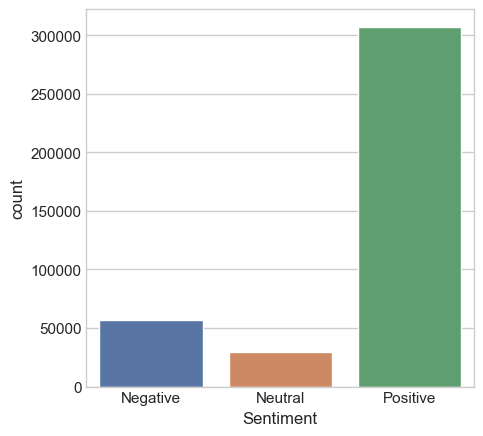

In [12]:
# Look at the class distribution. Obviously weighted toward positive.
fignum=1
fig, ax = plt.subplots(num=fignum, nrows=1, ncols=1, figsize=[5,5], dpi=100, clear=True)
ax = sns.countplot(x='Sentiment', data=dfDeDup, ax=ax)
plt.show()
fig.tight_layout()
#Save
sFile='AS08-{}.png'.format(fignum)
#plt.savefig(sFile)

### Quick look at the data
A quick look at 100 characters of the first and last 15 elements of the full text in the data gives an idea of what is in the data. Even this brief look shows several challenges:
- incorrect capitalization
- misspelled words
- contractions (correct and incorrect)
- possessive nouns using appostrophe s
- improper words (e.g., gotta)
- words that are used as proper names (my dog Max)
- numbers, prices, and percents
- quoted text
- html

We have to decide what might make a difference if we fix, versus what we ignore because it won't matter.

In [13]:
nLines = 15
np.random.seed(seed=1234)
srPeek = dfDeDup.loc[np.random.choice(dfDeDup['Text'].index, nLines*2, replace=False)]['Text']
peek_at_srtext(srPeek)


 35249: A great summer drink just got better!  Though not quite as frisky as the original, this makes a terr
114880: i ordered certified organic raw cacao powder. i recieved non organic CAROB powder.<br />i don't thin
408246: Best clam chowder I know and I've tried lots. For one, it has lots of clams instead of mostly potato
322872: I've been concerned recently about the reported dangers of drinking soymilk. Though these dangers ar
352172: My cats go absolutely nuts over Kitty Kaviar. They will beg for it and harass us for it throughout t
160515: The Jamaican Blue Mountain Blend coffee I purchase is wonderful.  I have tried others, but I keep co
348543: I have been eating an assortment of bulk candy and ,tho' they are not in bulk, strawberries and crea
233801: smells like good food...no cardboard dog food!  dogs eat less and are satisfied sooner!<br /><br />f
447700: A local health food store rep recommended organic raspberry leaf tea to get my system back on track 
542912: Beats compe

### Examine Records for HTML content
This next function counts the number of text entries that contain at least one HTML tag, and it keeps an example of what html it finds. 

Turns out there is a lot of html in these reviews, mostly things like  
- `<br />`
- `<a href="http://www.amazon.com/gp/product/B000NV83EG">`
- `<span class="tiny">` 

None of this is likely to be helpful. 

In [14]:
# How many records contain HTML?
# This is a simple pattern
# sHtmlPattern = '<.*?>'
# But it will miss html tags that have quotes embedded in an attribute.
# Match any HTML tag. https://haacked.com/archive/2004/10/25/usingregularexpressionstomatchhtml.aspx/
sHtmlPattern = '''</?\w+((\s+\w+(\s*=\s*(?:".*?"|'.*?'|[\^'">\s]+))?)+\s*|\s*)/?>'''

def countRecordsWithHtml(sr):
    cnt=0
    found = set()
    pattern = re.compile(sHtmlPattern, flags=re.IGNORECASE)
    def findHtml(text):
        nonlocal cnt
        nonlocal found
        m = re.search(pattern,text)
        if m:
            cnt = cnt+1
            found.add(m.group(0)[:15])
    sr.apply(findHtml)
    return(cnt, found)

countRecordsWithHtml(dfDeDup['Text'])

(103115, {'<a href="http:/', '<br />', '<p>', '<span class="ti'})

### Exercise 3 - Remove html
**Points 0.2**  
This first cleaning function must remove all html constructs.
- Input is a string
- Replace every HTML tag with a space (use the sHtmlPattern)
- Strip any trailing and leading space from the string.
- Return a cleaned string

[Instructions](#Instructions)

In [15]:
def remove_html( sText ):
    cleaned_text = re.sub(sHtmlPattern,' ',sText)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

In [16]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

srWithHtml = pd.Series( {1:'Reference Product: <br /> <a href="http://www.amazon.com/gp/product/B000NV83EG"> for details.',
                         2:'I don\'t LIKE <a href="http://www.amazon.com/gp/product/B000NV83EG"> for this',
                         3:'<P> Look at me, \nI can SHOUT </P>  ',
                         4:'<br /> one <br /> TWO <br />'})

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

assert remove_html(srWithHtml[1]) == 'Reference Product:     for details.' 
assert remove_html(srWithHtml[4]) == 'one   TWO'
assert remove_html(srWithHtml[2]) == 'I don\'t LIKE   for this' 
assert remove_html(srWithHtml[3]) == 'Look at me, \nI can SHOUT' 


### Exercise 4 - Expand common contractions
**Points 0.2** 

Contractions can be quite complex, as shown in these articles:  
- https://en.wikipedia.org/wiki/English_auxiliaries_and_contractions 
- https://en.wikipedia.org/wiki/Contraction_(grammar)

However, there are a few forms that are pretty consistent. Using the dictionary given, write a function that finds the contraction pattern and substitutes the expansion. Explicitly ignore case in this function.

[Instructions](#Instructions)

In [17]:
# This isn't perfect, but it catches a lot of common contractions. 
# The dictionary contains the regular expression pattern as the key, 
# the value is the replacement text when found.
# - first few are some common special cases
# - then handle really common substitutions like n't, 've, etc.
# When we tokenize, we generally throw away the apostophe part anyway, so
# - since it is difficult with 's to disambiguate between possessive and contractions, just chop off
# - since it is difficult with 'd to disambiguation between did, would, and had, just chop it off
diContractionPatterns = { 
    "i\'m"   : "i am",
    "can\'t" : "cannot",
    "\'cause": "because", 
    "won\'t" : "will not",
    "y'all"  : "you all",
    "ya'll"  : "you all",
    "n\'t"   : " not",
    "\'ve"   : " have",
    "\'ll"   : " will",
    "\'re"   : " are",
    "\'s"    : "",
    "\'d"    : "",
    }

#https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72
def expand_contractions(text, contraction_mapping=diContractionPatterns):
    contractions_pattern = re.compile("|".join(map(re.escape, contraction_mapping.keys(  ))), flags=re.IGNORECASE)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())  
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    return(expanded_text)


In [18]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          
# It also contains hidden tests that are run by the autograder.

srWithCtrct = pd.Series( {1:"I'm using Spot's $2.50 stuff. I haven't worried about it 'cause we're friends.",
                          2:"What isn't great they'll throw away, but he'd keep it!!",
                          3:"We're not there even though we could've been and should've been, we can't.",
                          4:"How'd y'all do that? We'll know when he's coming back won't we?",
                          5:"The store's possesive is different from he's coming."})

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

assert expand_contractions( srWithCtrct[1]) == "i am using Spot $2.50 stuff. I have not worried about it because we are friends."
assert expand_contractions( srWithCtrct[2]) == "What is not great they will throw away, but he keep it!!"
assert expand_contractions( srWithCtrct[3]) == 'We are not there even though we could have been and should have been, we cannot.'
assert expand_contractions( srWithCtrct[4]) == "How you all do that? We will know when he coming back will not we?"
assert expand_contractions( srWithCtrct[5]) == 'The store possesive is different from he coming.'



### Examine Records for words separated by slashes
This next function counts the number of records that have words that are separated by a slash. Tokenizers don't seem to handle this well and just leave the two words together. Looks like there are a lot of entries with this pattern. 

In [19]:
# How many records have words that are slashed?
sSlashPattern = "\w+/\w+"

def countRecordsWithSlashes(sr):
    cnt=0
    found = set()
    pattern = re.compile(sSlashPattern, flags=re.IGNORECASE)
    def findSlash(text):
        nonlocal cnt
        nonlocal found
        m = re.search(pattern,text)
        if m:
            cnt = cnt+1
            found.add(m.group(0))
    sr.apply(findSlash)
    return(cnt, found)

countRecordsWithSlashes(dfDeDup['Text'])

(37833,
 {'1/pod',
  'Low/no',
  'open/spoiled',
  'tan/copper',
  'half/kilo',
  'poodle/terrier',
  'greasy/watery',
  'wanted/expected',
  'delicious/amazing',
  '40c/oz',
  'lavender/chamomile',
  'Corgi/border',
  'strong/bitter',
  'couple/few',
  'bikes/hikes',
  '93/7',
  'frozen/fresh',
  'have/don',
  'people/companies',
  'seasonings/spices',
  'bergamot/black',
  'fiber/no',
  'starbucks/etc',
  'veggies/herbs',
  '95/month',
  'bicycle/mountain',
  'camping/roadtrip',
  'fabric/rope',
  '50/tin',
  'island/coconut',
  'GF/soy',
  'daughter/husband',
  'dachshund/beagle',
  'bland/weak',
  'fitness/health',
  'sandwiches/munching',
  'p/s',
  '75/bottle',
  'deaths/illnesses',
  'spills/drips',
  'stiff/flaky',
  'gritty/of',
  'teeth/breath',
  'pompadour/teekanne',
  'chemicals/or',
  'retiring/downsizing',
  'herbs/ingredients',
  'Lab/Rhodesdian',
  'quality/ingredient',
  '9/21',
  'reflux/gerd',
  'unless/until',
  'hamburger/hotdog',
  'coffee/capp',
  'roast/bold',


### Exercise 5 - Separate words that are joined by slashes or hyphens
**Points: 0.4**  
The above words are more likely to be useful if separated. There seem to be two consistent patterns that we'll make an attempt to fix.
- For `word`/`word` where `word` has only alphabetic characters, usually the author means `and` or `or`, which are stopwords that might be removed later, just substitute `and` for the slash. 
- For `A`/`B` where `A` starts with one or more digits followed by 0 or more alphabetic characters, and `B` is 0 or more digits followed by 1 or more alphabetic characters, usually the author means `A per B`, so substitute `per` for the slash
- Other tokens containing slashes can be anything, maybe even a date, so leave them alone.  

The other character that is often used to separate words is the dash, for example: `self-centered`. 
- For `word`-`word` where `word` has only alphabetic characters, replace the dash with a space.

When we use the function later, the case will all be lower. However, you should explicitly ignore case in this function. You will need different slash patterns than the one used above.

[Instructions](#Instructions)

In [20]:
def separate_slashwords( sText ):

    x=re.findall(r"([a-zA-Z]+/[a-zA-Z]+(?:/[a-zA-Z]+)*)",sText,re.I)
    if x:
        for s in x:
            replac=re.sub('/'," and ", s)
            sText=sText.replace(s,replac,1)
    y=re.findall(r"(\d+[a-zA-Z]*/\d*[a-zA-Z]+(?:/\d+[a-zA-Z]*/\d*[a-zA-Z]+)*)",sText,re.I)
    if y:
        for s1 in y:
            replac=re.sub('/'," per ", s1)
            sText=sText.replace(s1,replac,1)
    z=re.findall(r"((?:[a-zA-Z]+-[a-zA-Z]+)+(?:-[a-zA-Z]+)*)",sText,re.I)
   
    if z:
        for s in z:
            replac=re.sub(r'-'," ", s)
            sText=sText.replace(s,replac,1)
   
    return sText

In [21]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

srWithSlashes = pd.Series( { 1:"This is a medium-to-big entry. \nAlso with moist/gritty packages of crackers/snacks.",
                             2:"a baker/cake/pie caters to intolerance/sensitivity of the 5oz/100g of desert",
                             3:"What happens if the -- slash 'Late/Cappucino' is quoted or -4/ball, has a comma?",
                             4:"Things to leave include 40/30 or 24/16oz and 35/tbs is ok, 10/2012 is not",
                             5:"Self-centered actions are hole-in-the-wall reactions - at best",
                             6:"Test single letter separation like jack-o-lantern and a-e-i-o-u"
                           })

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

assert separate_slashwords( srWithSlashes[1]) == 'This is a medium to big entry. \nAlso with moist and gritty packages of crackers and snacks.'
assert separate_slashwords( srWithSlashes[2]) == 'a baker and cake and pie caters to intolerance and sensitivity of the 5oz per 100g of desert'
assert separate_slashwords( srWithSlashes[3]) == "What happens if the -- slash 'Late and Cappucino' is quoted or -4 per ball, has a comma?"
assert separate_slashwords( srWithSlashes[4]) == 'Things to leave include 40/30 or 24 per 16oz and 35 per tbs is ok, 10/2012 is not'
assert separate_slashwords( srWithSlashes[5]) == 'Self centered actions are hole in the wall reactions - at best'
assert separate_slashwords( srWithSlashes[6]) == 'Test single letter separation like jack o lantern and a e i o u'


### Exercise 6 - Final cleaning
**Points 0.5**  

The following function uses the above steps to clean up the data. Your cleaned version will be compared against the instructor's version to test the whole dataset. This will take a minute or two to run.

[Instructions](#Instructions)

In [22]:
def final_cleaning( sr ):
    # Loop through each item in the sequence
    srOut = sr.apply(remove_html)
    srOut = srOut.apply(expand_contractions)
    srOut = srOut.apply(separate_slashwords)
    return( srOut ) 

sCleanedData = os.path.join(sSaveDir,'AS08a-cleandata.pkl')
data = final_cleaning(dfDeDup['Text'])
#data.to_pickle(sCleanedData)


In [23]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

test = pd.read_pickle(sCleanedData)

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
assert sum(data == test) == data.shape[0]


In [24]:
# Just to get everyone on the same page
data = pd.read_pickle(sCleanedData)
target = dfDeDup['SentimentVal']

## Prepare Data for Vectorizing
This portion defines the data preparation and cleaning steps that will be used prior to vectorizing the data. As such, we will now be working primarily with the Training data. 

[Instructions](#Instructions)

### Test/Train split
Being careful to avoid data leakage, now is the time to split the test and training data, keeping it in Pandas series for now. 
Since this should be second nature as well, just run the following code.

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.25, random_state=0)

print('Train records: {:7}'.format(X_train.shape[0]))
print(' Test records: {:7}'.format(X_test.shape[0]))

assert sorted(X_train.index) == sorted(Y_train.index)
assert sorted(X_test.index) == sorted(Y_test.index)
assert isinstance(X_train, pd.core.series.Series)

# Make sure class balances look decent compared to the target
dfBalance = pd.DataFrame()
dfBalance['Target']  = checkClassBalance(target)
dfBalance['Y_train'] = checkClassBalance(Y_train)
dfBalance['Y_test']  = checkClassBalance(Y_test)
dfBalance



Train records:  295449
 Test records:   98484


,Target,Y_train,Y_test
2,0.779462,0.779728,0.778665
0,0.144969,0.144983,0.144927
1,0.075569,0.075289,0.076408


### Random sample of X_train for analysis

With this type of text for sentiment analysis, lemmatizing might help to reduce the dimensionallity. Unfortunately, that works best with parts of speech, so this might be too time consuming. To test the timing, let's first pull out a subset of our training data to try this. For this subset, we'll include equal numbers of positive and negative reviews.

In [26]:
nSamples = 15
np.random.seed(seed=42)
srSubSet = X_train.loc[np.random.choice(Y_train[Y_train==2].index, nSamples, replace=False)]
srSubSet = srSubSet.append(X_train.loc[np.random.choice(Y_train[Y_train==0].index, nSamples, replace=False)])

peek_at_srtext(srSubSet)


 93450: It tastes and feels like you are eating real pasta!!!  It is not mushy or slimy like some other glut
386069: Very good tea, just what it said it would be and quick delivery. Would recommend.
428492: This coffee has a wonderfully rich flavor.  My husband, who brews his coffee quite strong, was pleas
399809: ------------------------------------------------------- Illy Issimo Coffee Drink, Cappucino, 8.45-Ou
309378: Really good lollipops. These are my favorite. I will say though, after I bought these, I found them 
224873: This was such a better deal than the "brick and mortar" price.  I ordered two so I could get the fre
154459: My husband was quite reluctant to try the different coffees for the Keurig machine. We like a mild m
100398: I rate this sauce as hot as 357 Silver edition and Da Bomb ground zero.  It is supposedly hotter tha
105683: Heat up very quickly and taste great.  I like to add chicken to it.  Nice for at work.
112859: Good product at a fraction of the candy stor

### Exercise 7 - See how much lemmatization costs
**Points: 1.0**  
The first function below is a utility that you will need to bridge between the standard NLTK part of speech tagger and the wordnet lemmatizer. 

[Instructions](#Instructions)

In [27]:
# Utility function to convert a treebank part of speech indicator
# that is returned by nltk.pos_tag into a wordnet POS indicator 
# needed for wnlt.lemmatize
class tb2wn():
    def __init__(self):
        self.dctMap = {'N': wn.NOUN, 'J': wn.ADJ, 'V': wn.VERB, 'R': wn.ADV}
        
    def translate(self, treebank_tag):    
        try:
            wn_tag = self.dctMap[ treebank_tag[0] ]
        except:
            wn_tag = None
        return wn_tag    



The intent of this next function is to reduce the vocabulary 
- lemmatize to reduce the number of words while retaining semantic intent
- remove non-word tokens that are unlikely to contribute to identifying the sentiment 
- since sentiment is likely conveyed in verbs, adjectives, and adverbs, replace all nouns with the word `noun`

This function is a little complex. Be careful and follow this sequence.
- The input is a string, but it may contain multiple sentences.
- Tokenize the input into sentences (nltk.sent_tokenize)
- For each sentence
  - tokenize (nltk.word_tokenize)
  - tag the result with parts of speech (nltk.pos_tag)
  - for each (token, tag) pair
    - if the token is a noun, replace it with the word `noun` 
    - if the token is a verb, adverb, or adjective, then lemmatize it using WordNetLemmatizer  
    - if the token has anything other than alphabetic characters, drop it    
- Join all the resulting tokens from all sentences back into a string using `' '` (space) as the separator between tokens
- Remove any leading or trailing spaces from the final string before returning

[Instructions](#Instructions)

In [28]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Use global classes so we don't have to init for every call
wnlt  = WordNetLemmatizer()
posxl = tb2wn()    
def tokenize_and_lemmatize( sText ):
    texts = nltk.sent_tokenize(sText)
    final = ''
    for text in texts:
        words = nltk.word_tokenize(text)
        pos = nltk.pos_tag(words)
        lemmatized_output = ''
        for i, j in zip(words, pos):
            if posxl.translate(j[1]) == 'n':
                lemmatized_output+='noun '
            elif posxl.translate(j[1]) == 'j' or posxl.translate(j[1]) == 'v' or posxl.translate(j[1]) == 'r' or posxl.translate(j[1]) == 'a':
                lemmatized_output+=str(wnlt.lemmatize(i,posxl.translate(j[1])))
                lemmatized_output+=' '
            else:
                lemmatized_output+=str(i) 
                lemmatized_output+=' '
        final_output = ''
        for word in lemmatized_output.split():
            w = re.match(r'[a-zA-Z]+',word)
            if w:
                final_output+=w.group(0)
                final_output+=' '
        final+=final_output.strip()
        final+=' '
    return(final.strip())

In [29]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

srWithSent = pd.Series({1: "This is a sentence with little content. however, in the U.S. obsequious comments are not the best.",
                        2: "The contents of this comment include 8 per gallon likeable material. Hope you enjoy it.",
                        3: "Some of these words should lemmatize to the same: good, better, best",
                        4: "Against all better judgement, I bought this $1.28 bad product. --- It is no worse than lousy.",
                        5: "Why can we not keep against, not, and no? You train with slashes",
                        6: "Some might have date or dates like 14 January 2019 or 6/20/2012.",
                        7: 'This was such a better deal than the "Brick and Mortar" price.'
                       })


# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
assert tokenize_and_lemmatize( srWithSent[1] ) == 'This be a noun with little noun however in the noun obsequious noun be not the best'
assert tokenize_and_lemmatize( srWithSent[2] ) == 'The noun of this noun include per noun likeable noun noun you enjoy it'
assert tokenize_and_lemmatize( srWithSent[3] ) == 'Some of these noun should lemmatize to the same good good best'
assert tokenize_and_lemmatize( srWithSent[4] ) == 'Against all good noun I buy this bad noun It be no bad than lousy'
assert tokenize_and_lemmatize( srWithSent[5] ) == 'Why can we not keep against not and no You train with noun'
assert tokenize_and_lemmatize( srWithSent[6] ) == 'Some might have noun or noun like noun or'
assert tokenize_and_lemmatize( srWithSent[7] ) == 'This be such a good noun than the noun and noun noun'


In [30]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.   

def series_strings_equal(a, b):
    if not (isinstance(a, pd.core.series.Series) and
            isinstance(b, pd.core.series.Series) and
            (a.shape == b.shape)):
        raise ValueError("a and b must be pandas series of the same shape")
    lstMissed = []
    for idx, s in a.iteritems():
        if not (re.sub("\s+", " ", s.strip()) == re.sub("\s+", " ", b[idx].strip())):
            lstMissed = lstMissed + idx
    return lstMissed  

srSubSetLemmatized = srSubSet.apply(tokenize_and_lemmatize)
srEx5 = os.path.join(sSaveDir,'AS08a-Ex5Subset.pkl')
#srSubSetLemmatized.to_pickle(srEx5)
srTest = pd.read_pickle(srEx5)

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
assert len(series_strings_equal(srTest, srSubSetLemmatized)) == 0


In [31]:
# Look at the same subset that has been lemmatized
peek_at_srtext(srSubSetLemmatized)

 93450: It taste and noun like you be eat real noun It be not mushy or noun like some other gluten free noun
386069: Very good noun just what it say it would be and quick noun Would recommend
428492: This noun have a wonderfully rich noun My noun who brew his noun quite strong be pleased with the no
399809: Illy noun noun noun noun noun noun noun be a noun of noun noun an Italian noun best know for their n
309378: Really good noun These be my favorite I will say though after I buy these I find them cheap at noun
224873: This be such a good noun than the noun and noun noun I order two so I could get the free noun noun b
154459: My noun be quite reluctant to try the different noun for the noun noun We like a mild noun noun and 
100398: I noun this noun as hot as noun noun and noun noun noun noun It be supposedly hot than noun hot non 
105683: noun up very quickly and taste great I like to add noun to it noun for at noun
112859: Good noun at a noun of the noun noun noun plus free noun nou

In [32]:
# Let's use the srSubSet to estimate how long it would take to lematize 
# all of the data. On a 2 GHz, 4 core mobile Intel processor, the estimate is over 35 minutes.

result = %timeit -n4 -r3 -o  srSubSet.apply(tokenize_and_lemmatize)

fEstimate = (result.best / srSubSet.shape[0]) * data.shape[0] / 60

print('Estimated time to process data (min): {:.1f}'.format(fEstimate))

507 ms ± 13.4 ms per loop (mean ± std. dev. of 3 runs, 4 loops each)
Estimated time to process data (min): 108.6


### Lemmatize the data
Once again, to get everyone on the same page, the full dataset has been pre-lemmatized for further processing

In [33]:
sTrainedLemmatized = os.path.join(sSaveDir,'AS08a-trainlemmatizeddata.pkl')
sTestLemmatized    = os.path.join(sSaveDir,'AS08a-testlemmatizeddata.pkl')

#X_trn_le = X_train.apply(tokenize_and_lemmatize)
#X_tst_le = X_test.apply(tokenize_and_lemmatize)
#X_trn_le.to_pickle(sTrainedLemmatized)
#X_tst_le.to_pickle(sTestLemmatized)

In [34]:
X_trn_le = pd.read_pickle(sTrainedLemmatized)
X_tst_le = pd.read_pickle(sTestLemmatized)

## Vectorizing and Modeling
In this section, compare CountVectorizing for Naive Bayes with TFIDF Vectorizing for Linear SVC.  
Use F1-score for comparing results for each class, and the F1-score macro average for overall comparison.  
The next cell imports the scikit-learn functions needed.  
The following cell defines a utility function for extracting the f1 score.

[Instructions](#Instructions)


In [35]:
# These are the scikit-learn functions that will be used

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.classification import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from sklearn.feature_extraction import text


In [36]:
# This function extracts the F1-scores for each class, as well as the macro average.
def model_results( mdl, X_trn, X_tst, Y_trn, Y_tst ):
    Y_trn_p = mdl.predict(X_trn)
    res_trn = classification_report( Y_trn, Y_trn_p, target_names=sentiment_labels, output_dict=True )
    
    Y_tst_p = mdl.predict(X_tst)
    res_tst = classification_report( Y_tst, Y_tst_p, target_names=sentiment_labels, output_dict=True ) 
        
    def res_print( res ):
        sScore = 'f1-score'
        sMA = 'macro avg'
        sr = pd.Series()
        sr.name = sScore
        for lbl in sentiment_labels:
            dct = res[lbl]
            sr[lbl] = dct[sScore]
        sr[sMA] = res[sMA][sScore]
        return sr
        
    srTrn = res_print(res_trn)
    srTst = res_print(res_tst)
    return (Y_trn_p, Y_tst_p, srTrn, srTst)

### Exercise 8 - Create stopword list
**Points: 0.3**  
It is likely that stopwords will be common in all the classes, but we'll be very conservative with this. In the next function, you will build the stopword list that will be used. We'll only use the stopwords that are common for both the NLTK and Scikit-learn libraries. In addition, don't include words with negative content in the stopword list.
- Use both the NLTK and sklearn stopword lists
- Keep only the words that are common to both lists
- Remove any words that are in the `lstExclude` input list
- Add any words that are in the `lstInclude` input list
- Return a set.

[Instructions](#Instructions)

In [37]:
def build_stopwords( lstExclude, lstInclude ):
    from nltk.corpus import stopwords 
    from sklearn.feature_extraction import stop_words
    nltk_stop_words = list(stopwords.words('english'))
    sklearn_stop_words = list(stop_words.ENGLISH_STOP_WORDS)
    common_stop_words = list(set(nltk_stop_words).intersection(sklearn_stop_words))
    exclude_stop_words = [item for item in common_stop_words if item not in lstExclude]
    final_stop_words = set(exclude_stop_words + lstInclude)
    return final_stop_words

In [38]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

lstExclude = ['against', 'no', 'nor', 'not', 'very']
lstInclude = ['noun']

my_stopwords = build_stopwords( lstExclude, lstInclude )

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
assert isinstance(my_stopwords, set)
assert 115 == len(my_stopwords)

assert not 'not'  in my_stopwords, 'Incorrect exclusion'
assert not 'very'  in my_stopwords, 'Incorrect exclusion'
assert not 'even' in my_stopwords, 'Did not exclude word not common'
assert not 'doesn' in my_stopwords, 'Did not exclude word not common'

checklist = {'noun','and', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both',
             'but', 'by', 'can', 'do', 'down', 'during', 'or', 'through', 'to', 'too', 'under',}
for w in checklist:
    assert w in my_stopwords


### Exercise 9 - CountVectorize
**Points: 0.5**  

Use CountVectorizor to process the `X_trn_le` and `X_tst_le` data.
- Only allow 100,000 features
- Use up to (and including) 3 ngram
- Use `my_stopwords`
- process using lowercase (the default)

The result must be three new variables:
- `X_trn_bowc` - the vectorized `X_trn_le`
- `X_tst_bowc` - the vectorized `X_tst_le`
- `cVocab`     - the vocabulary learned by the vectorizer (a dictionary)


In [39]:
X_trn_bowc = pd.Series()
X_tst_bowc = pd.Series()
cVocab = {}
vectorizer = CountVectorizer(lowercase = True, stop_words = my_stopwords, ngram_range = (1,3), max_features= 100000)
X_trn_bowc = vectorizer.fit_transform(X_trn_le)
cVocab = vectorizer.vocabulary_
X_tst_bowc =  vectorizer.transform(X_tst_le)

In [40]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------
assert cVocab['fantastic'] == 23776
assert cVocab['just highly recommend'] == 41094
assert cVocab['absolutely'] == 155
assert cVocab['no'] == 56718
assert cVocab['like real'] == 46259

assert (295449, 100000) == X_trn_bowc.shape
assert (98484, 100000) == X_tst_bowc.shape



### Exercise 10 - Naive Bays Model
**Points: 0.5**  

Fit a Naive Bays model using `X_trn_bowc`. The result must be in a variable named `mdl_nb`

In [41]:
mdl_nb = None

naive_bayes = MultinomialNB()
mdl_nb = naive_bayes.fit(X_trn_bowc,Y_train)


In [42]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

(Y_trn_nbp, Y_tst_nbp, srTrnNb, srTstNb) = model_results(mdl_nb, X_trn_bowc, X_tst_bowc, Y_train, Y_test)

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

np.testing.assert_almost_equal(srTrnNb.values, [0.730, 0.495, 0.921, 0.716], decimal=2, verbose=True)
np.testing.assert_almost_equal(srTstNb.values, [0.666, 0.365, 0.910, 0.647], decimal=2, verbose=True)


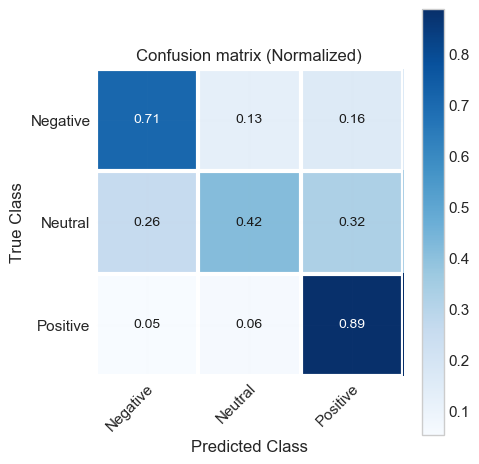

In [43]:
# Plot the confusion matrix
ax = gutil_plot_confusion_matrix(2, Y_test, Y_tst_nbp, class_names=sentiment_labels, normalize=True) 

### Exercise 11 - TFIDFVectorize
**Points: 0.5**  

Use TfidfVectorizer to process the `X_trn_le` and `X_tst_le` data.
- Only allow 100,000 features
- Use up to (and including) 3 ngram
- Use `my_stopwords`
- process using lowercase (the default)

The result must be three new variables:
- `X_trn_bowt` - the vectorized `X_trn_le`
- `X_tst_bowt` - the vectorized `X_tst_le`
- `tVocab`     - the vocabulary learned by the vectorizer (a dictionary)


In [44]:
X_trn_bowt = pd.Series()
X_tst_bowt = pd.Series()
tVocab = {}
vectorizer = TfidfVectorizer(lowercase = True, stop_words = my_stopwords, ngram_range = (1,3), max_features= 100000)
X_trn_bowt = vectorizer.fit_transform(X_trn_le)
tVocab = vectorizer.vocabulary_
X_tst_bowt =  vectorizer.transform(X_tst_le)




In [45]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

assert tVocab['fantastic'] == 23776
assert tVocab['add little like'] == 948
assert tVocab['take ship'] == 85363
assert tVocab['good not bitter']== 33237
assert tVocab['bitter'] == 7861

assert (295449, 100000) == X_trn_bowt.shape
assert (98484, 100000) == X_tst_bowt.shape


### Exercise 12 - LinearSVC Model
**Points: 0.5**  
Fit a LinearSVC model using `X_trn_bowt`. The result must be in a variable named `mdl_ls`

- use a balanced class weight
- use the most appropriate setting for `dual`
- set the random_state to `0`
- use the OneVsRestClassifier to speed up your work. You can set n_jobs=3 since we are training 3 classifiers.

In [46]:
mdl_ls = None

clf = LinearSVC(class_weight = 'balanced',random_state = 0,dual=False)
classif = OneVsRestClassifier(clf,n_jobs = 3)
mdl_ls = classif.fit(X_trn_bowt, Y_train)


In [47]:
## This is an automatically graded test cell.
# The public tests help you determine whether your solutions are correct.                          

(Y_trn_lsp, Y_tst_lsp, srTrnLs, srTstLs) = model_results(mdl_ls, X_trn_bowt, X_tst_bowt, Y_train, Y_test)

# Public tests (make sure your function passes these tests)
# ---------------------------------------------------------

np.testing.assert_almost_equal(srTrnLs.values, [0.897, 0.802, 0.966, 0.889], decimal=2, verbose=True)
np.testing.assert_almost_equal(srTstLs.values, [0.653, 0.323, 0.910, 0.628], decimal=2, verbose=True)


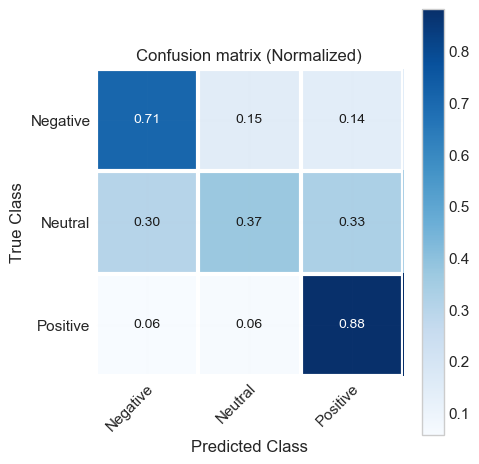

In [48]:
# Plot the confusion matrix
ax = gutil_plot_confusion_matrix(3, Y_test, Y_tst_lsp, class_names=sentiment_labels, normalize=True) 

### Exercise 13 - Conclusion
**Points: 0.4**  
Answer these questions in the cell below. 

1. Which model had the least difference in the macro average between training and test data? 
2. Which model had the best f1 score on the test data for Negative sentiments?

[Instructions](#Instructions)

(Answers based on code below)
1. Naive Bays model.
2. Naive Bays model.

In [52]:
print(srTrnNb['macro avg']-srTstNb['macro avg'])
print(srTrnLs['macro avg']-srTstLs['macro avg'])
print(srTstNb['Negative'])
print(srTstLs['Negative'])

0.06852416873756062
0.2605189361406599
0.6660307226735963
0.6533084208491721
